<a href="https://colab.research.google.com/github/DuarteVn/EDA_Desafio_Horus/blob/main/Desafio_Predicao_Satisfacao_Cliente_Vinicius_Duarte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predição da Satisfação do Cliente

In [ ]:
#@markdown # 1: Instalação de Bibliotecas e Configuração Inicial
#@markdown ---
#@markdown Nesta etapa, importa-se as biblioteca necessárias para o funcionamento do projeto
#@markdown
#@markdown
#@markdown
#@markdown
#@markdown

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Configuração para os gráficos
sns.set_style('whitegrid')


In [ ]:
#@markdown # 2. Carregamento e Preparação Inicial dos Dados
#@markdown ---
#@markdown - Carregar o arquivo CSV e realizar uma preparação inicial
#@markdown - Converter colunas de data para o formato `datetime`
#@markdown - Filtrar o dataset para incluir apenas os pedidos com status `delivered` (entregue)
#@markdown - Remover linhas com dados de data faltantes
#@markdown - Remover linhas duplicadas


# Carregar o conjunto de dados a partir do arquivo CSV
df = pd.read_excel('dados_desafio.xlsx')

# Converter colunas de data para o formato datetime
date_cols = ['data_hora_pedido', 'pedido_aprovado', 'pedido_com_entregador', 'pedido_entregue', 'tempo_entregue_estimado']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Filtrar apenas por pedidos entregues e remover nulos em datas críticas
df_delivered = df[df['status_pedido'] == 'delivered'].copy()
df_delivered.dropna(subset=date_cols, inplace=True)
df_delivered.drop_duplicates(inplace=True)

print("Dados carregados e filtrados. Total de pedidos entregues para análise:", len(df_delivered))
df_delivered.head()

Dados carregados e filtrados. Total de pedidos entregues para análise: 99791


,id_pedido,tipo_pagamento,prestacoes,valor_pagamento,id_cliente,status_pedido,data_hora_pedido,pedido_aprovado,pedido_com_entregador,pedido_entregue,...,comprimento_produto,altura_produto,largura_produto,cep_vendedor,cidade_vendedor,estado_vendedor,id_unica_cliente,cep_cliente,cidade_cliente,estado_cliente
0,05d5a67b06f86425711075939a164657,credit_card,1,18.38,716c95338343be76a421f05145f6d9b7,delivered,2017-10-24 09:17:09.000,2017-10-24 09:28:15.000,2017-10-25 22:45:59.000,2017-10-26 14:13:59.000,...,16.0,7.0,12.0,4870,sao paulo,SP,b4acaca510f847f9927914b51f9b0874,9861,sao bernardo do campo,SP
1,b1f9820e61b6a6a7643c961eaf4f217d,credit_card,1,28.23,6e550daa4d9d07414a598ee4682289a0,delivered,2018-04-09 18:06:35.971,2018-04-09 18:31:35.962,2018-04-10 19:24:56.995,2018-04-16 18:05:41.971,...,20.0,15.0,15.0,6716,cotia,SP,9abf4d8d20ca191ce59eb6227cf53d6d,38270,campina verde,MG
2,b27f6a3ed9bfe29879c912b10bcf081b,credit_card,9,92.57,dd774d127953e12f6953a9d36e6a3cc4,delivered,2018-01-02 20:32:35.981,2018-01-02 20:50:16.022,2018-01-08 12:32:48.019,2018-01-16 20:52:39.014,...,60.0,20.0,30.0,13232,campo limpo paulista,SP,dc446a1ea0c8cc3eb1cd31896f6cf00f,12919,braganca paulista,SP
3,a182c021b0561e70031de925b3991fb3,credit_card,4,176.99,1d93c38087f43927ad29cdbd73a1a01b,delivered,2018-04-02 20:25:56.035,2018-04-02 20:35:17.030,2018-04-04 18:13:12.029,2018-04-11 11:14:30.970,...,17.0,11.0,16.0,14840,guariba,SP,14691264ea396cd3bd71ebbe36bc6771,29278,arace,ES
4,8e76f4ac6aee1d6013e40279de68a7cf,credit_card,10,110.56,e085989aa21e36b90469d6940aefe23c,delivered,2017-08-05 17:52:44.026,2017-08-05 18:10:09.034,2017-08-07 17:39:02.966,2017-08-15 19:59:47.962,...,50.0,7.0,33.0,14940,ibitinga,SP,06c211500493e0aa2c584346c15a1d81,95770,feliz,RS


In [ ]:
#@markdown # 3. Engenharia de Features e Definição da Variável Alvo
#@markdown ---
#@markdown Criar novas features (variáveis) a partir dos dados existentes

#@markdown Features de Tempo:
#@markdown
#@markdown - `tempo_de_entrega`: O tempo total, em dias, desde a aprovação do pagamento até a entrega.
#@markdown - `atraso_na_entrega`: A diferença, em dias, entre a data real da entrega e a data estimada. Valores positivos indicam atraso. Este é um forte candidato a ser um fator importante.
#@markdown - `tempo_ate_envio`: O tempo que a loja levou para despachar o produto.
#@markdown
#@markdown
#@markdown
#@markdown


# Criar a variável alvo (target)
df_delivered['Satisfeito'] = np.where(df_delivered['score_avaliacao'] >= 4, 1, 0)

# Criar features de tempo
df_delivered['tempo_de_entrega'] = (df_delivered['pedido_entregue'] - df_delivered['pedido_aprovado']).dt.days
df_delivered['atraso_na_entrega'] = (df_delivered['pedido_entregue'] - df_delivered['tempo_entregue_estimado']).dt.days
df_delivered['tempo_ate_envio'] = (df_delivered['pedido_com_entregador'] - df_delivered['pedido_aprovado']).dt.days

# Selecionar apenas as colunas que usaremos e tratar valores nulos
features = [
    'prestacoes', 'valor_pagamento', 'valor_frete', 'peso_produto',
    'tempo_de_entrega', 'atraso_na_entrega', 'tempo_ate_envio',
    'tipo_pagamento', 'categoria_produto'
]
target = 'Satisfeito'

df_model = df_delivered[features + [target]].copy()
df_model['categoria_produto'].fillna('desconhecida', inplace=True)
df_model.dropna(inplace=True)

print("Variável alvo e novas features criadas com sucesso.")
df_model.head()

Variável alvo e novas features criadas com sucesso.


/tmp/ipython-input-3554584641.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_model['categoria_produto'].fillna('desconhecida', inplace=True)


,prestacoes,valor_pagamento,valor_frete,peso_produto,tempo_de_entrega,atraso_na_entrega,tempo_ate_envio,tipo_pagamento,categoria_produto,Satisfeito
0,1,18.38,7.78,100.0,2,-11,1,credit_card,perfumaria,1
1,1,28.23,18.23,350.0,6,-21,1,credit_card,automotivo,1
2,9,92.57,13.57,7000.0,14,-8,5,credit_card,papelaria,1
3,4,176.99,18.99,335.0,8,-14,1,credit_card,relogios_presentes,1
4,10,110.56,15.10,650.0,10,-16,1,credit_card,moveis_decoracao,1


In [ ]:
#@markdown # 4. Preparação dos Dados para o Modelo de Machine Learning
#@markdown ---
#@markdown  Preparar os dados no formato que ele espera.
#@markdown 1.  **Seleção de Features:** Definimos quais colunas serão usadas para prever o resultado.
#@markdown 2.  **Divisão Treino/Teste:** Separar os dados em um conjunto de treino (usado para ensinar o modelo) e um de teste (usado para avaliar o desempenho em dados que ele nunca viu).
#@markdown 3.  **Pré-processamento:** Criar um `Pipeline` para automatizar o tratamento das features:
#@markdown  - `StandardScaler`: Colocar todas as variáveis numéricas na mesma escala, evitando que uma domine a outra.
#@markdown - `OneHotEncoder`: Transforma variáveis categóricas em um formato numérico que o modelo entende.
#@markdown

# Identificar colunas numéricas e categóricas
numeric_features = ['prestacoes', 'valor_pagamento', 'valor_frete', 'peso_produto', 'tempo_de_entrega', 'atraso_na_entrega', 'tempo_ate_envio']
categorical_features = ['tipo_pagamento', 'categoria_produto']

# Dividir os dados em treino e teste
X = df_model[features]
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Criar um pipeline de pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


In [ ]:
#@markdown #  5. Treinamento do modelo
#@markdown ---
#@markdown Algoritmo `RandomForestClassifier` lida bem com a complexidade dos dados
#@markdown
#@markdown Primeiro pré-processa os dados e em seguida, os envia para o classificador. O comando `.fit()` inicia o processo de treinamento com os dados de treino.
#@markdown
#@markdown
#@markdown
#@markdown

# Criar o pipeline do modelo completo
rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))])

# Treinar o modelo
print("Iniciando o treinamento do modelo...")
rf_model.fit(X_train, y_train)
print("Treinamento concluído!")

Iniciando o treinamento do modelo...
Treinamento concluído!


Acurácia do Modelo: 0.8246
AUC-ROC: 0.7144

Relatório de Classificação:
              precision    recall  f1-score   support

Insatisfeito       0.78      0.28      0.42      4402
  Satisfeito       0.83      0.98      0.90     15554

    accuracy                           0.82     19956
   macro avg       0.81      0.63      0.66     19956
weighted avg       0.82      0.82      0.79     19956



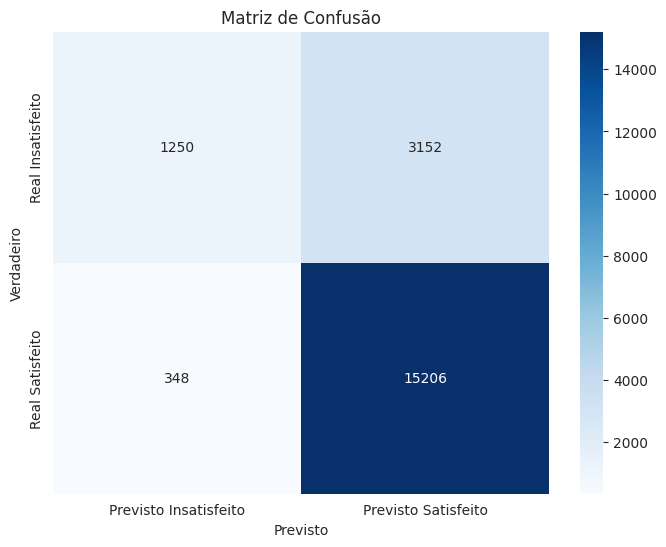

In [ ]:
#@markdown ## **6. Avaliação de Desempenho do Modelo**
#@markdown
#@markdown
#@markdown
#@markdown
#@markdown
#@markdown
#@markdown
#@markdown
#@markdown - Acurácia: Percentual geral de acertos.
#@markdown - AUC-ROC: Uma métrica que avalia a capacidade do modelo de distinguir entre as classes (satisfeito vs. insatisfeito). Quanto mais perto de 1, melhor.
#@markdown - Relatório de Classificação: Mostra métricas detalhadas:
#@markdown    - `Precision`: Dos que o modelo previu como insatisfeitos, quantos realmente eram
#@markdown     - `Recall`: Dos que eram realmente insatisfeitos, quantos o modelo conseguiu identificar
#@markdown - Matriz de Confusão: Visualizar os acertos e erros do modelo.


# Fazer previsões com os dados de teste
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Avaliar as métricas
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred, target_names=['Insatisfeito', 'Satisfeito'])
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Acurácia do Modelo: {accuracy:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}\n")
print("Relatório de Classificação:")
print(report)

# Plotar a Matriz de Confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Previsto Insatisfeito', 'Previsto Satisfeito'],
            yticklabels=['Real Insatisfeito', 'Real Satisfeito'])
plt.title('Matriz de Confusão')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()

/tmp/ipython-input-3721438627.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')


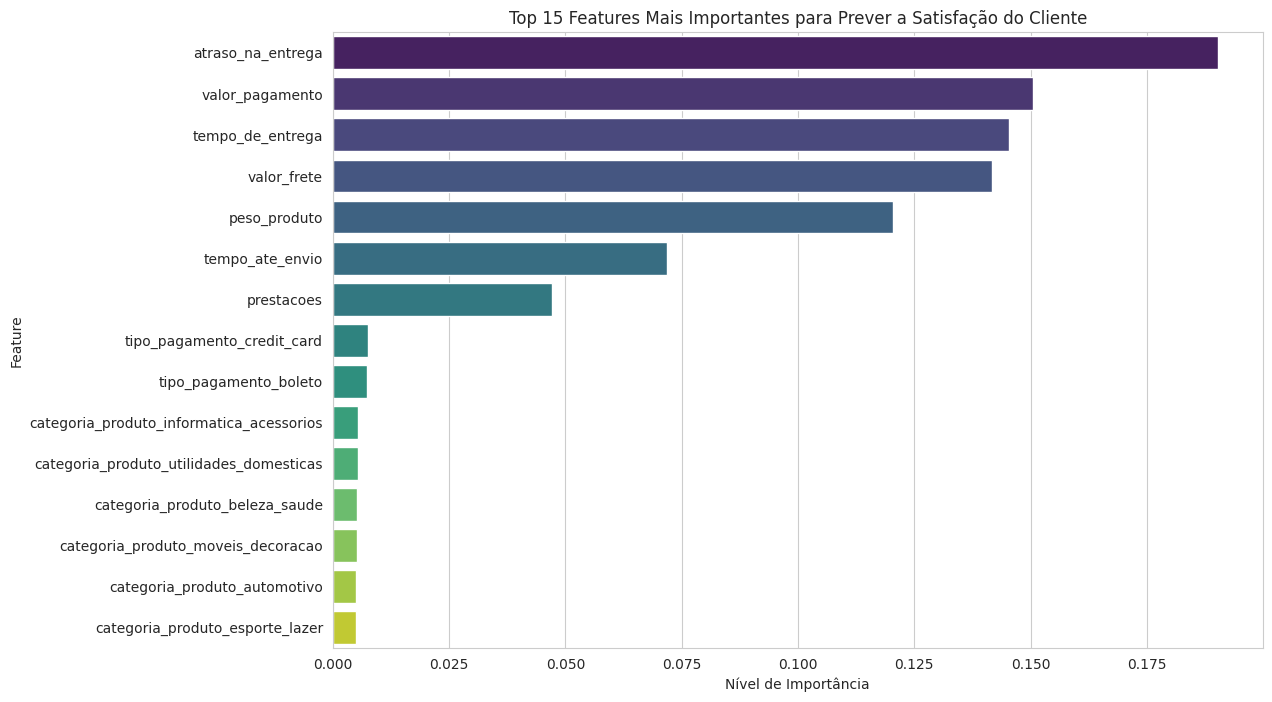

As 10 features mais importantes:
                                     Feature  Importance
5                          atraso_na_entrega    0.190370
1                            valor_pagamento    0.150546
4                           tempo_de_entrega    0.145240
2                                valor_frete    0.141697
3                               peso_produto    0.120308
6                            tempo_ate_envio    0.071840
0                                 prestacoes    0.047049
8                 tipo_pagamento_credit_card    0.007560
7                      tipo_pagamento_boleto    0.007364
56  categoria_produto_informatica_acessorios    0.005463


In [ ]:
#@markdown #  7. Análise dos fatores mais importantes
#@markdown ---
#@markdown O que o modelo aprendeu. Quais fatores ele considerou mais importantes para decidir se um cliente ficará satisfeito ou não

#@markdown  O gráfico o ranking dos fatores que mais impactam a satisfação do cliente.

#@markdown Variáveis como `atraso_na_entrega`, `valor_pagamento`, e `tempo de entrega`ocupam as posições mais altas no ranking.
#@markdown  - Para o cliente, a experiência de compra online só termina quando o produto está em suas mãos.
#@markdown - Fatores secundários, como `valor_frete` e `prestacoes`, também são importantes.
#@markdown
#@markdown Com base nesses insights seria interessante um otimização da cadeia logistica, investir em rotas, seleção de transportadoras com melhor performance e redução de tempo de processamento interno

#@markdown O modelo pode servir como um sistema de alerta proativo. Ao identificar pedidos com alta probabilidade de insatisfação, a equipe de atendimento pode agir de forma preventiva para garantir uma experiencia positiva


# Extrair os nomes das features após o one-hot encoding
feature_names_raw = rf_model.named_steps['preprocessor'].get_feature_names_out()
feature_names = [name.replace('num__', '').replace('cat__', '') for name in feature_names_raw]

# Obter a importância das features do modelo treinado
importances = rf_model.named_steps['classifier'].feature_importances_

# Criar um DataFrame para visualização
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotar as 15 features mais importantes
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')
plt.title('Top 15 Features Mais Importantes para Prever a Satisfação do Cliente')
plt.xlabel('Nível de Importância')
plt.ylabel('Feature')
plt.show()

print("As 10 features mais importantes:")
print(feature_importance_df.head(10))

In [ ]:

#@markdown #8. Conclusão e Aplicação Prática
#@markdown ---
#@markdown A análise de importância das features confirma que a experiência logística é o principal motor da satisfação do client. Fatores como `atraso_na_entrega`, `tempo_de_entrega` e `valor_frete` são os mais decisivos.

#@markdown Seria interessante um otimização da cadeia logistica, investir em rotas, seleção de transportadoras com melhor performance e redução de tempo de processamento interno

#@markdown O modelo pode servir como um sistema de alerta proativo. Ao identificar pedidos com alta probabilidade de insatisfação, a equipe de atendimento pode agir de forma preventiva para garantir uma experiencia positiva
